# <a id='toc1_'></a>[Introduction](#toc0_)

This notebook analyses the proteins within the PCNet network that are proximal to only one of the two species BMI GWAS results. We examine the distribution of $NPS_r$ and $NPS_h$ scores for BMI to define thresholds for rat-specific and human-specific networks. We compare the tissue expression patterns of the species-specific network and the conserved BMI network. We then analyze these species-specific networks, along with the conserved network, in the context of a expanded network of all proteins with high NPS in one or both species. 

**Figures produced in this notebook:**
* Figure 6A - Scatterplot showing the definition of subnetworks based on NPS scores.
* Figure 6B - Bar chart comparing the sources of genes in each of the subnetworks
* Figure 6C - Human tissue gene expression results for each of the subnetworks
* Figure 6D - Mouse tissue gene expression results for each of the subnetworks
* Figure 6E - Data for this figure is generated in this notebook, the hierarchy figure was produced in Cytoscape
* Supplemental Figure 6 - Definitions of Species-Specific networks

**Note on re-running the analysis:**
* If `rerun_analysis==True` the hierarchical community detection and annotation of the expanded network will be repeated. Because this process is not deterministic the results will vary slightly from the study results. 
* If `rerun_analysis==False` the hierarchy will be loaded from file.

In [1]:
rerun_analysis = False

**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [Set Up](#toc2_)    
  - [Libraries and paths](#toc2_1_)    
  - [Input Data](#toc2_2_)    
- [Defining species specific Networks](#toc3_)    
  - [Distributions of the species NPS](#toc3_1_)    
  - [Set thresholds](#toc3_2_)    
  - [Identify subgraphs](#toc3_3_)    
    - [ADDED Assess the impact of thresholds on network size](#toc3_3_1_)    
    - [END ADDED](#toc3_3_2_)    
  - [Visualize the species specific networks](#toc3_4_)    
  - [Assess seed gene fractions](#toc3_5_)    
- [Tissue enrichments of conserved & species specific networks](#toc4_)    
  - [Get gene lists for each subnetwork](#toc4_1_)    
  - [Import tissue enrichment results](#toc4_2_)    
  - [Visualize tissue enrichment results](#toc4_3_)    
- [Hierarchical Community Detection of Species Specific Networks](#toc5_)    
  - [Define the expanded network](#toc5_1_)    
  - [Perform hierarchical community detection](#toc5_2_)    
  - [Annotate the hiearchy with GO terms](#toc5_3_)    
  - [Annotate the global systems map](#toc5_4_)    
  - [Upload the expanded systems map](#toc5_5_)    
  - [Visualize over-represented communities](#toc5_6_)    
  - [ADDED MGD Enrichment](#toc5_7_)    
  - [END ADDED](#toc5_8_)    
  - [ADDED Table 7 Analysis](#toc5_9_)    
  - [END ADDED](#toc5_10_)    
- [Scaled Figures](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Set Up](#toc0_)

## <a id='toc2_1_'></a>[Libraries and paths](#toc0_)

In [2]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from tqdm import tqdm
import cdapsutil
import ndex2
from scipy.stats import hypergeom
from statsmodels.stats.multitest import fdrcorrection
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

DISCLAIMIER: cdapsutil is experimental and may contain errors and interfaces may change


In [3]:
# Set up directory paths. Defaults to the Data/ and Figures/ folders within the repository.
cwd = os.path.dirname(os.getcwd())
DATADIR = os.path.join(cwd, "Data/")
FIGDIR = os.path.join(cwd, "Figures/")

In [4]:
sys.path.append(cwd)
from analysis_functions import *
from updated_netcoloc_functions import *

## <a id='toc2_2_'></a>[Input Data](#toc0_)

In [5]:
pc_nodes, G = load_pcnet()

number of nodes:
18820

number of edges:
2693109


In [8]:
# load data, contains original subgraphs
data = pd.read_csv(DATADIR + "outputs/rat_human_BMI_all_NPS.tsv", sep = "\t", index_col=0)
data.head()

,NPS_r,NPS_h,NPS_hr
gene,,,
A1BG,0.125314,-0.488576,-0.061226
A1CF,2.540447,2.186042,5.553524
A2M,0.651845,-0.581848,-0.379275
A2ML1,-1.315517,-1.108608,1.458393
A3GALT2,-0.546107,-0.243477,0.132964


In [6]:
# load seed genes
seed_bin_human_BMI = pd.read_csv(DATADIR+"inputs/human_BMI_all_seed_genes.txt", header=None)[0].tolist()
print("Number of human BMI seeds:", len(seed_bin_human_BMI))

seed_bin_rat_BMI=pd.read_csv(DATADIR+'inputs/ratBMI_seed_genes.txt',sep='\t')['0'].tolist()
print("Number of rat BMI seeds:", len(seed_bin_rat_BMI))

Number of human BMI seeds: 1958
Number of rat BMI seeds: 295


In [9]:
# classify each gene based on seed gene status
data = data.assign(rat_seed=[1 if gene in seed_bin_rat_BMI else 0 for gene in data.index])
data = data.assign(human_seed=[1 if gene in seed_bin_human_BMI else 0 for gene in data.index])

# <a id='toc3_'></a>[Defining species specific Networks](#toc0_)

## <a id='toc3_1_'></a>[Distributions of the species NPS](#toc0_)

To determine appropriate thresholds for each species we examine the distribution of network proximity scores (NPS). 

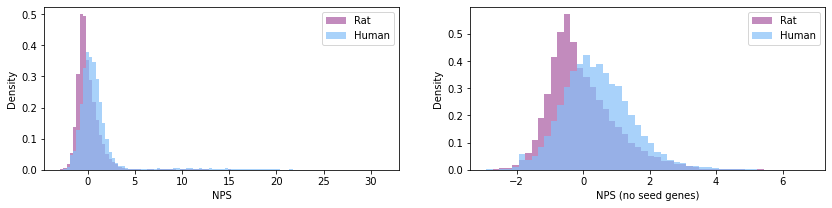

In [10]:
matplotlib.rcParams.update({'font.size': 14})
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14, 3))
_, bins, _ = ax1.hist(data.NPS_r, bins=100, alpha=0.7, density=True, label="Rat", color="#a95aa1")
_ = ax1.hist(data.NPS_h, bins=bins, alpha=0.7, density=True, label="Human", color="#85c0f9")
ax1.set_ylabel("Density")
ax1.set_xlabel("NPS")
ax1.legend()

_, bins, _ = ax2.hist(data[data.rat_seed==0].NPS_r, bins=50, alpha=0.7, density=True, label="Rat", color="#a95aa1")
_ = ax2.hist(data[data.human_seed==0].NPS_h, bins=bins, alpha=0.7, density=True, label="Human", color="#85c0f9")
ax2.set_ylabel("Density")
ax2.set_xlabel("NPS (no seed genes)")
ax2.legend()

In [11]:
# Summarize the NPS scores, including seed genes
data.loc[:, ("NPS_r", "NPS_h")].describe()

,NPS_r,NPS_h
count,18820.000000,18820.000000
mean,0.166117,1.064944
std,1.819963,3.034380
min,-2.908312,-3.953688
25%,-0.699091,-0.227384
50%,-0.220273,0.450951
75%,0.566990,1.240185
max,31.286290,34.273300


In [12]:
# Summarize the NPS_r scores, excluding seed genes
data[data.rat_seed==0].NPS_r.describe(percentiles=[0.5, 0.75, 0.8, 0.85, 0.9, 0.95])

count    18525.000000
mean        -0.013611
std          1.030633
min         -2.908312
50%         -0.237388
75%          0.518693
80%          0.729556
85%          1.005072
90%          1.354651
95%          1.952714
max          6.798332
Name: NPS_r, dtype: float64

In [11]:
# Summarise the NPS_h scores, excluding seed genes
data[data.human_seed==0].NPS_h.describe(percentiles=[0.5, 0.75, 0.8, 0.85, 0.9, 0.95])

count    16862.000000
mean         0.425921
std          1.047217
min         -3.953688
50%          0.348532
75%          1.069361
80%          1.240472
85%          1.464345
90%          1.742707
95%          2.219446
max          6.620334
Name: NPS_h, dtype: float64

## <a id='toc3_2_'></a>[Set thresholds](#toc0_)

Based on the above distributions we set:

* same-species threshold to be greater than $\mu_{sameSpecies} + \sigma_{sameSpecies}$
* other-species threshold to be less than $\mu_{otherSpecies}$
* expanded thresholds to give a network between 500-1000 genes.

**Combo thresholds are used as follows:**  

Conserved: $z_{rat}\bullet z_{human} > combo$  
  
Rat Only: $z_{rat}\bullet (z_{human} - 1) < combo$  
  
Human Only: $(z_{rat}-1)\bullet z_{human} < combo$

In [13]:
# set thresholds:
conserved = {"rat":1, "human":1, "combo":3}
rat_only = {"rat":1, "human":0.5, "combo":-2}
human_only = {"rat":0, "human":1.5, "combo":-4}

## <a id='toc3_3_'></a>[Identify subgraphs](#toc0_)

In [17]:
def sub_graph(data, rat_th_dict, human_th_dict, conserved_th_dict):
    """Wrapper function to assign each gene in data to a subnetwork based on the thresholds defined

    Args:
        data (pandas.DataFrame): DataFrame containing the genes and their NPS scores
        rat_th_dict (dict): A dictionary specifying the three thresholds to define the rat-Specific network
        human_th_dict (dict): A dictionary specifying the three thresholds to define the human-Specific network
        conserved_th_dict (dict): A dictionary specifying the three thresholds to define the conserved network

    Returns:
        pandas.DataFrame: The input data set with a new/updated subgraph column for all subnetworks
    """
    if "subgraph" not in data.columns:
        data = data.assign(subgraph="PCNet")
    else:
        data["subgraph"] = "PCNet"
    data = assign_sub_graph(data, th_dict = conserved_th_dict, name="conserved")
    data = assign_sub_graph(data, th_dict = rat_th_dict, name="rat")
    data = assign_sub_graph(data, th_dict = human_th_dict, name="human")
    return data

def assign_sub_graph(data, rat_th=None, human_th=None, combo_th=None, th_dict=None, name="conserved"):
    """Assigns sub_graph annotations based on input thresholds

    Args:
        data (_type_): _description_
        rat_th (_type_, optional): If assigning the rat-Specific network, rat-Specific thresholds. Defaults to None.
        human_th (_type_, optional): If assigning the human-Specific network, human-Specific thresholds. Defaults to None.
        combo_th (_type_, optional): If assigning the conserved network, conserved thresholds. Defaults to None.
        th_dict (_type_, optional): Dictionary of all thresholds.  Defaults to None.
        name (str, optional): Name of the subgraph being assigned. Defaults to "conserved".

    Returns:
        pandas.DataFrame: The input data set with a new/updated subgraph column for a single subnetwork
    """
    if th_dict is not None:
        rat_th = th_dict["rat"]
        combo_th = th_dict["combo"]
        human_th = th_dict["human"]
    if "subgraph" not in data.columns:
        data = data.assign(subgraph="PCNet")
    if name == "rat":
        data.loc[((data.NPS_r > rat_th) & (data.NPS_h < human_th) & (data.NPS_r * (data.NPS_h - 1) < combo_th)), 
                ("subgraph")] = "Rat-Specific"
    elif name == "human":
        data.loc[((data.NPS_r < rat_th) & (data.NPS_h > human_th) & ((data.NPS_r - 1)*(data.NPS_h) < combo_th)), 
                ("subgraph")] = "Human-Specific"
    else:
        data.loc[((data.NPS_r > rat_th) & (data.NPS_h > human_th) & (data.NPS_hr > combo_th)), ("subgraph")] = "Conserved"
    return data

In [18]:
# classify each gene based on membership to sub networks
data = assign_sub_graph(data, th_dict = conserved, name="conserved")
data = assign_sub_graph(data, th_dict = rat_only, name="rat")
data = assign_sub_graph(data, th_dict = human_only, name="human")

In [22]:
# number of genes in each subnetwork
print("Number of genes in each subnetwork:")
data.value_counts("subgraph", dropna=False)

Number of genes in each subnetwork:


subgraph
PCNet             16550
Human-Specific      925
Rat-Specific        688
Conserved           657
dtype: int64

In [20]:
# export the data
data.to_csv(DATADIR + "outputs/rat_only_human_only_networks.tsv", sep="\t")

### <a id='toc3_3_1_'></a>[ADDED Assess the impact of thresholds on network size](#toc0_)

In [21]:
data= pd.read_csv(DATADIR + "outputs/rat_only_human_only_networks.tsv", sep="\t")

def get_network_stats(G, genes):
    subG = nx.Graph(G.subgraph(genes))
    to_be_removed = [x for  x in subG.nodes() if subG.degree(x) < 1]
    subG.remove_nodes_from(to_be_removed)
    comps = nx.number_connected_components(subG)
    density = nx.density(subG)
    return comps, density
    

## <a id='toc3_4_'></a>[Visualize the species specific networks](#toc0_)

In [23]:
def plot_species_nps(data, subgraph, th_dict=None, ax=None, legend=None, fontsize=7):
    """Plot the species and conserved networks as a function of NPSh and NPSr.

    Args:
        data (pandas.DataFrame): Gene-subnetwork mapping
        subgraph (str): Name of the subnetwork
        th_dict (dict, optional): Thresholds to define the subnetwork. Defaults to None.
        ax (matplotlib.pyplot.Axes, optional): Axis to plot the figure on. Defaults to None.
        legend (str, optional): Input to seaborn to toggle legend. Defaults to None.
        fontsize (int, optional): Fontsize for plotting labels. Defaults to 7.
    """
    x_points = [(i+0.0001)/10 for i in range(-50,250)]
    if subgraph == "conserved":
        cmap = {"Conserved": "#F5793A", **{k:"grey" for k in ["Rat-Specific", "PCNet", "Human-Specific"]}}
        combo_line = [th_dict["combo"]/x for x in x_points if x > th_dict["combo"]/25]
        ax.plot([x for x in x_points if x > th_dict["combo"]/25], combo_line, color="#f5793a", linewidth=1)
        ax.text(x=10, y=30, s="$NPS_r > "+str(th_dict["rat"])+"$", color="#a95aa1", fontsize=fontsize)
        ax.text(x=10, y=26, s="$NPS_h > "+str(th_dict["human"])+"$", color="#85c0f9", fontsize=fontsize)
        ax.text(x=10, y=22, s="$NPS_{hr} > "+str(th_dict["combo"])+"$", color="#f5793a", fontsize=fontsize)
    elif subgraph == "rat":
        cmap = {"Rat-Specific": "#a95aa1", **{k:"grey" for k in ["Conserved", "PCNet", "Human-Specific"]}}
        combo_line = [th_dict["combo"]/(x-1) for x in x_points if x < 1 + th_dict["combo"]/25]
        ax.plot([x for x in x_points if x < 1 + th_dict["combo"]/25], combo_line, color="#f5793a", linewidth=1)
        ax.text(x=10, y=30, s="$NPS_r > "+str(th_dict["rat"])+"$", color="#a95aa1", fontsize=fontsize)
        ax.text(x=10, y=26, s="$NPS_h < "+str(th_dict["human"])+"$", color="#85c0f9", fontsize=fontsize)
        ax.text(x=10, y=22, s="$NPS_r(NPS_h-1) < "+str(th_dict["combo"])+"$", color="#f5793a", fontsize=fontsize)
    elif subgraph == "human":
        cmap = {"Human-Specific": "#85c0f9", **{k:"grey" for k in ["Rat-Specific", "PCNet", "Conserved"]}}
        combo_line = [1 + th_dict["combo"]/x for x in x_points if x > th_dict["combo"]/-6]
        ax.plot([x for x in x_points if x > th_dict["combo"]/-6], combo_line, color="#f5793a", linewidth=1)
        ax.text(x=10, y=30, s="$NPS_r < "+str(th_dict["rat"])+"$", color="#a95aa1", fontsize=fontsize)
        ax.text(x=10, y=26, s="$NPS_h > "+str(th_dict["human"])+"$", color="#85c0f9", fontsize=fontsize)
        ax.text(x=10, y=22, s="$NPS_h(NPS_r-1) < "+str(th_dict["combo"])+"$", color="#f5793a", fontsize=fontsize)
    else:
        cmap = {"Conserved": "#F5793A","Rat-Specific": "#a95aa1", "Human-Specific": "#85c0f9", "PCNet":"grey" }
    
    sns.scatterplot(data=data, x="NPS_h", y="NPS_r", hue="subgraph", palette=cmap, s=2, ax=ax, markers=True, alpha=0.8,
                legend=legend)
    if th_dict is not None:
        ax.hlines(y=th_dict["rat"], xmin=-5, xmax=25, color="#a95aa1", alpha=1, zorder=4, linewidth=1)
        ax.vlines(x=th_dict["human"], ymin=-5, ymax=25, color="#85c0f9", alpha=1, zorder=3, linewidth=1)
    ax.set_ylabel("NPS$_r$", fontsize=fontsize)
    ax.set_xlabel("NPS$_h$", fontsize=fontsize)
    ax.spines['left'].set(position=('data', 0.0), zorder=2)
    ax.spines['bottom'].set(position=('data', 0.0), zorder=2)
    ax.spines['top'].set_position(('data', 0.0))
    ax.spines['right'].set_position(('data', 0.0))
    ax.set_xticks([ 5, 10, 15, 20, 25, 30])
    ax.set_xticklabels(labels=[ 5, 10, 15, 20, 25, 30], fontsize=fontsize, zorder=10)
    ax.set_yticks([ 5, 10, 15, 20, 25, 30])
    ax.set_yticklabels(labels=[ 5, 10, 15, 20, 25, 30], fontsize=fontsize, zorder=10)

### Supplemental Figure 6A-C

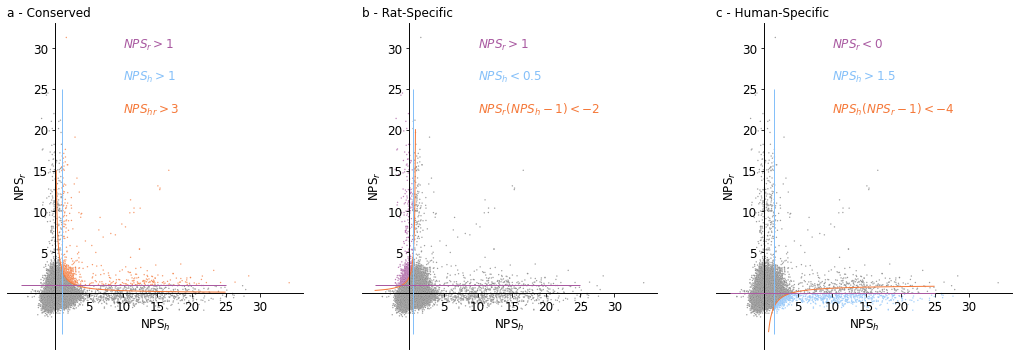

In [25]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
plot_species_nps(data, "conserved", conserved, ax1, fontsize=12)
plot_species_nps(data, "rat", rat_only, ax2, fontsize=12)
plot_species_nps(data, "human", human_only, ax3, fontsize=12)
ax1.set_title("a - Conserved", loc="left", fontsize=12)
ax2.set_title("b - Rat-Specific", loc="left", fontsize=12)
ax3.set_title("c - Human-Specific", loc="left", fontsize=12)
plt.savefig(FIGDIR + "Sup6_definition_of_networks.png", dpi=400, bbox_inches="tight")

### Figure 6A

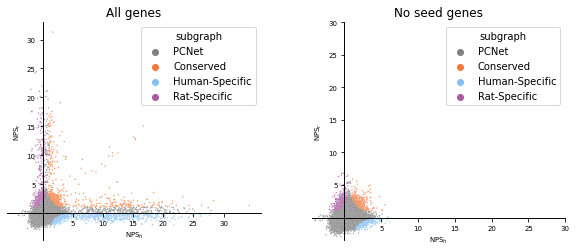

In [27]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
plot_species_nps(data, "all", ax=ax1, legend="brief")
plot_species_nps(data[data.rat_seed+data.human_seed==0], "all", ax=ax2, legend="brief")
_ = ax2.set_title("No seed genes")
_ = ax1.set_title("All genes")

## Assess varying thresholds for defining networks

Here we evaluate the effect of modifying the expanded NPS threshold, keeping the individual species NPS thresholds constant. 

In [30]:
test_data = data.copy()
combo_thresholds = [i/20 for i in range(10, 101)]
sizes = {}
for tau in combo_thresholds:
    rat_th = {"rat":1, "human":0.5, "combo":-1 * tau}
    human_th = {"rat":0, "human":1.5, "combo":-1 * tau}
    conserved = {"rat":1, "human":1, "combo": tau}
    test_data = sub_graph(test_data, rat_th, human_th, conserved)
    sizes[tau] = test_data.value_counts("subgraph", dropna=False)
size_df = pd.DataFrame.from_dict(sizes).T

### Supplemental Figure 6D

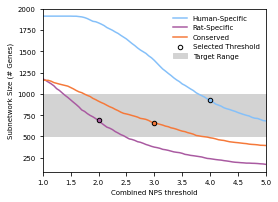

In [31]:
#plt.plot(size_df.index, size_df.Conserved, color="#f5793a", label="Conserved")
_, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(4,3)) #gridspec_kw ={'hspace':0.05})
plt.sca(ax1)
plt.plot(size_df.index, size_df["Human-Specific"], color="#85c0f9", label="Human-Specific", zorder=2)
plt.plot(size_df.index, size_df['Rat-Specific'], color="#a95aa1", label="Rat-Specific", zorder=2)
plt.plot(size_df.index, size_df['Conserved'], color="#F5793A", label="Conserved", zorder=2)
ax1.scatter(x=[3], y=[657], s=20, zorder=5, color="#F5793A", edgecolor="black")
ax1.scatter(x=[2], y=[688], s=20, zorder=5, color="#a95aa1", edgecolor="black")
ax1.scatter(x=[4], y=[925], s=20, zorder=5, color="#85c0f9", edgecolor="black")
ax1.scatter(x=[4], y=[800], s=20, zorder=0, color="white", edgecolor="black", label="Selected Threshold")
plt.ylabel("Subnetwork Size (# Genes)", fontsize=7)
plt.xlabel('expanded NPS threshold', fontsize=7)
#plt.hlines(y=657, xmin=0, xmax=5, color="#F5793A", linestyle="--", linewidth=1, label="Conserved")
ax1.fill_between(size_df.index, 1000, 500, color="lightgrey", label="Target Range", zorder=1)
#plt.hlines(y=[500, 1000], xmin=0, xmax=5, color="black", linestyle="--", linewidth=1, label="Target Range")
plt.xlim(1, 5)
ax1.tick_params(labelsize=7)
plt.legend(fontsize=7, frameon=False)

plt.savefig(FIGDIR + "Sup6d_threshold_network_structure.png", dpi=600, bbox_inches="tight")

## <a id='toc3_5_'></a>[Assess seed gene fractions](#toc0_)

In [32]:
data = data.assign(overlapping_seeds=1*(data.rat_seed + data.human_seed==2))
data.head()

,gene,NPS_r,NPS_h,NPS_hr,rat_seed,human_seed,subgraph,overlapping_seeds
0,A1BG,0.125314,-0.488576,-0.061226,0,0,PCNet,0
1,A1CF,2.540447,2.186042,5.553524,0,0,Conserved,0
2,A2M,0.651845,-0.581848,-0.379275,0,0,PCNet,0
3,A2ML1,-1.315517,-1.108608,1.458393,0,0,PCNet,0
4,A3GALT2,-0.546107,-0.243477,0.132964,0,1,PCNet,0


In [34]:
# summarize the source of genes in each subgraph
subgraph_stats = data.groupby("subgraph").sum().loc[:, ("rat_seed", "human_seed", "overlapping_seeds")]
subgraph_stats = subgraph_stats.join(data.groupby("subgraph").count().loc[:, "NPS_r"])
subgraph_stats = subgraph_stats.rename(columns={"NPS_r":"count"})
subgraph_stats["Network"] = subgraph_stats["count"].values - subgraph_stats.loc[:,("rat_seed", "human_seed", "overlapping_seeds")].sum(axis=1).values
subgraph_stats.drop(columns=["count"], inplace=True)
subgraph_stats = subgraph_stats.loc[:,( "human_seed", "overlapping_seeds","rat_seed", "Network") ]

In [35]:
# summarize the source of network implicated genes in each subgraph
subgraph_stats["Network (Conserved)"] = 0
subgraph_stats.loc["Conserved", ("Network (Conserved)")] = subgraph_stats.loc["Conserved", ("Network")]
subgraph_stats["Network (Rat)"] = 0
subgraph_stats.loc["Rat-Specific", ("Network (Rat)")] = subgraph_stats.loc["Rat-Specific", ("Network")]
subgraph_stats["Network (Human)"] = 0
subgraph_stats.loc["Human-Specific", ("Network (Human)"
                                    )] = subgraph_stats.loc["Human-Specific", ("Network")]
subgraph_stats.drop(columns = ["Network"], inplace=True)

In [36]:
subgraph_stats.columns = ["Human Seed", "Shared Seed", "Rat Seed", "Network (Conserved)","Network (Rat)","Network (Human)"]

### Figure 6B

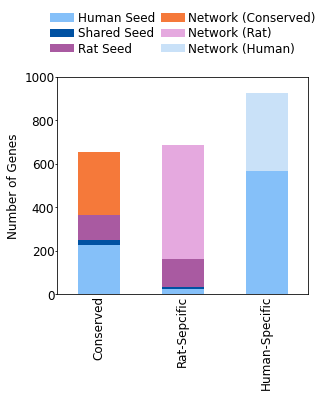

In [43]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4.5,4))
subgraph_stats.loc[["Conserved", "Rat-Specific", "Human-Specific"]].plot(kind="bar", stacked=True, ax=ax,
                                                                color=["#85c0f9", "#0051a2","#a95aa1", "#F5793a", "#e5a9df", "#c9e1f8"])
plt.legend(ncol=2, handletextpad=0.3, labelspacing=0.2, borderpad=0.4, columnspacing=0.5, fontsize=12, frameon=False, loc="upper center", bbox_to_anchor=(0.25, 1.1, 0.5, 0.25))
#plt.ylim((0, 1300))
#ax.get_legend().remove()
plt.xticks(fontsize=12)
plt.yticks([0,200, 400, 600, 800, 1000],fontsize=12)
ax.set_xticklabels(labels=["Conserved", "Rat-Sepcific", "Human-Specific"])
plt.xlabel(None)
ax.tick_params(axis='x', pad=1, length=0)
ax.tick_params(axis='y', pad=1, length=2)
plt.ylabel("Number of Genes", fontsize=12)
plt.savefig(FIGDIR + "6b_species_specific_bars.png", dpi=400, bbox_inches="tight")

# <a id='toc4_'></a>[Tissue enrichments of conserved & species specific networks](#toc0_)

Tissue enrichments were done using:
* Human: http://genetics.wustl.edu/jdlab/tsea/
* Mouse: https://tissueenrich.gdcb.iastate.edu/

For mouse tissue enrichments, all genes were converted to mouse orthologs using the MGD data downloaded for functional enrichment. 

In [44]:
def to_mouse_genes(gene_list, mgi_df):
    orthos = mgi_df.loc[mgi_df.human_ortholog.isin(gene_list), ("gene_name")].unique()
    return orthos

## <a id='toc4_1_'></a>[Get gene lists for each subnetwork](#toc0_)

In [46]:
# create lists of genes within the three subgraphs
with open(DATADIR + "outputs/subgraph_genes_conserved.txt", 'w') as fp:
    fp.write('\n'.join(data.loc[data.subgraph=="Conserved"].gene.values))
with open(DATADIR + "outputs/subgraph_genes_rat.txt", 'w') as fp:
    fp.write('\n'.join(data.loc[data.subgraph=="Rat-Specific"].gene.values))
with open(DATADIR + "outputs/subgraph_genes_human.txt", 'w') as fp:
    fp.write('\n'.join(data.loc[data.subgraph=="Human-Specific"].gene.values))

In [47]:
mgi_df = load_MGI_mouseKO_data(url='http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt',
                                        map_using="mgi", update=False, data_loc=DATADIR+"Reference/")

In [48]:
# create subgraph lists with mouse orthologs
with open(DATADIR + "outputs/subgraph_genes_conserved_mouse_ortho.txt", 'w') as fp:
    fp.write('\n'.join(to_mouse_genes(data.loc[data.subgraph=="Conserved"].gene.values, mgi_df)))
with open(DATADIR + "outputs/subgraph_genes_rat_mouse_ortho.txt", 'w') as fp:
    fp.write('\n'.join(to_mouse_genes(data.loc[data.subgraph=="Rat-Specific"].gene.values, mgi_df)))
with open(DATADIR + "outputs/subgraph_genes_human_mouse_ortho.txt", 'w') as fp:
    fp.write('\n'.join(to_mouse_genes(data.loc[data.subgraph=="Human-Specific"].gene.values, mgi_df)))

## <a id='toc4_2_'></a>[Import tissue enrichment results](#toc0_)

In [49]:
# read in the results of tissue enrichments in human tissue
human_te_files = {"C":DATADIR+"outputs/C_TSEA.txt", "R":DATADIR+"outputs/R_TSEA.txt", "H":DATADIR+"outputs/H_TSEA.txt"}
human_te = {}
for subgraph in human_te_files:
    tsea = pd.read_csv(human_te_files[subgraph], index_col=0, sep="\t")
    tsea[subgraph+"_FDR"] = tsea["0.05"].apply(lambda x: -1 * np.log10(float(x.split(" ")[2])))
    human_te[subgraph] = tsea.loc[:, (subgraph+"_FDR")]
human_te = pd.DataFrame.from_dict(human_te)

In [50]:
# read in the results of tissue enrichments in mouse tissue
mouse_te_files = {"C":DATADIR+"outputs/C_TSEA_mouse_ENCODE.tsv", 
                    "R":DATADIR+"outputs/R_TSEA_mouse_ENCODE.tsv", 
                    "H":DATADIR+"outputs/H_TSEA_mouse_ENCODE.tsv"}
mouse_te = {}
for subgraph in mouse_te_files:
    tsea = pd.read_csv(mouse_te_files[subgraph], index_col=0, sep="\t")
    tsea[subgraph+"_FDR"] = -1* np.log10(fdrcorrection(10**(-1* tsea["-Log10PValue"]))[1])
    mouse_te[subgraph] = tsea.loc[:, (subgraph+"_FDR")]
mouse_te = pd.DataFrame.from_dict(mouse_te)

## <a id='toc4_3_'></a>[Visualize tissue enrichment results](#toc0_)

### Figure 6C

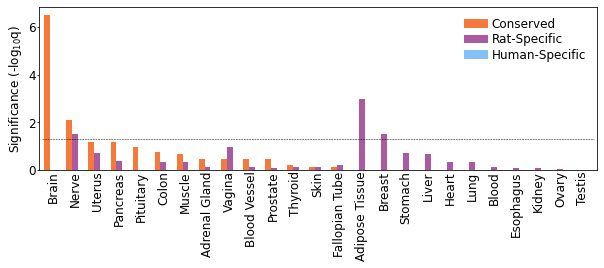

In [60]:
human_te.columns = ["Conserved", "Rat-Specific", "Human-Specific"]
human_te = human_te.sort_values(by=["Conserved", "Rat-Specific"], ascending=False)
fig, ax = plt.subplots(figsize=(10,3))
human_te.plot.bar(ax=ax, width=0.8, color=["#f5793a", "#a95aa1", "#85c0f9"], fontsize=12)
ax.set_ylabel("Significance (-log$_{10}$q)", fontsize=12)
ax.set_xlabel(None)
plt.hlines(-1 *np.log10(0.05),-0.5, 24.5, color="black", linestyle="dashed", linewidth=0.5)
plt.legend(fontsize=12, frameon=False,handletextpad=0.3, labelspacing=0.2 )
plt.tick_params(axis='x', pad=1, length=0)
plt.tick_params(axis='y', pad=1, length=2)
plt.yticks([0,2,4,6])
plt.savefig(FIGDIR+"6c_tissue_enrichment_human_GTEx.png", bbox_inches="tight", dpi=400)


### Figure 6D

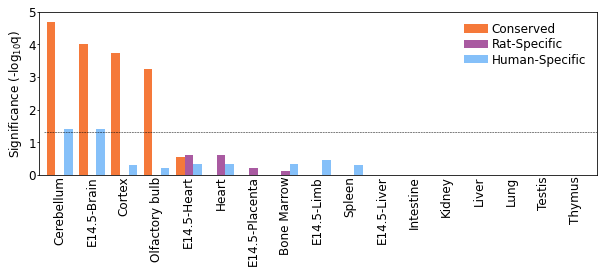

In [59]:
mouse_te.columns = ["Conserved", "Rat-Specific", "Human-Specific"]
mouse_te = mouse_te.sort_values(by=["Conserved", "Rat-Specific", "Human-Specific"], ascending=False)
fig, ax = plt.subplots(figsize=(10,3))
mouse_te.plot.bar(ax=ax, width=0.8, color=["#f5793a", "#a95aa1", "#85c0f9"], fontsize=12)
ax.set_ylabel('Significance (-log$_{10}$q)', fontsize=12)
ax.set_xlabel(None)
plt.hlines(-1 *np.log10(0.05),-0.5, 24.5, color="black", linestyle="dashed", linewidth=0.5)
plt.legend(fontsize=12, frameon=False,handletextpad=0.3, labelspacing=0.2 )
plt.tick_params(axis='x', pad=1, length=0)
plt.tick_params(axis='y', pad=1, length=2)
plt.yticks([0,1,2,3,4,5])
#plt.title("Enrichment of Tissue-Specific Genes from mouse ENCODE")
plt.savefig(FIGDIR+"6d_tissue_enrichment_mouse_ENCODE.png", bbox_inches="tight", dpi=400)


# <a id='toc5_'></a>[Hierarchical Community Detection of Species Specific Networks](#toc0_)

## <a id='toc5_1_'></a>[Define the expanded network](#toc0_)

To create a unified network for analyzing conserved, rat-specific and human-specific genes we take all genes with $NPS_r > 1$ **or** $NPS_h$ > 1.5 - corresponding to the same-species thresholds used to define the rat-specific and human-specific networks. 

In [63]:
if 'gene' in data.columns:
    data = data.set_index('gene', drop=True)

In [67]:
# extract just the nodes meeting our criteria
data["in_expanded"] = data.apply(lambda x: (x.NPS_r > rat_th['rat']) or (x.NPS_h > human_th['human']), axis=1)
G_all = G.subgraph(nodes=data.loc[data["in_expanded"]].index)

In [68]:
print("Number of genes in expanded network:", len(G_all.nodes))

Number of genes in combined network: 6025


### Figure 6A

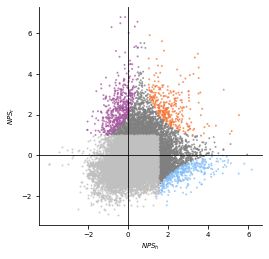

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
cmap = {"Conserved": "#F5793A","Rat-Specific": "#a95aa1", "Human-Specific": "#85c0f9", "PCNet":"grey" }
sns.scatterplot(data=data[((data.rat_seed+data.human_seed==0) & (data.in_expanded))], x="NPS_h", y="NPS_r", hue="subgraph", palette=cmap, 
                s=3, ax=ax, markers=True, alpha=0.8, edgecolor='face')
sns.scatterplot(data=data[((data.rat_seed+data.human_seed==0) & (~data.in_expanded))], x="NPS_h", y="NPS_r", color='silver',
                s=3, ax=ax, markers=True, alpha=0.8, edgecolor='face')
ax.set_xticks([ -2 ,0, 2, 4, 6])
ax.set_yticks([ -2 ,0, 2, 4, 6])
ax.tick_params(labelsize=7)
plt.xlabel("$NPS_h$", fontsize=7)
plt.ylabel("$NPS_r$", fontsize=7)
ax.get_legend().remove()
#plt.legend(ncol=1, handletextpad=0.05, labelspacing=0.1, borderpad=0.4, fontsize=7, frameon=False, markerscale=0.5,
#          labels=["expanded Network", "Conserved", "Human-Specific", "Rat-Specific"])
ax.spines['top'].set_position(('data', 0.0))
ax.spines['right'].set_position(('data', 0.0))
plt.savefig(FIGDIR+"6a_subnetworks_no_seeds.png",  dpi=400, bbox_inches="tight")


## <a id='toc5_2_'></a>[Perform hierarchical community detection](#toc0_)

In [72]:
if rerun_analysis:
    cd = cdapsutil.CommunityDetection()
    G_all_cx = ndex2.create_nice_cx_from_networkx(G_all)
    G_all_cx.set_name("Combined Rat-Human-Conserved BMI Network")
    G_all_hier = cd.run_community_detection(G_all_cx, algorithm='hidefv1.1beta',arguments={'--maxres':str(20)})
    print('Hierarchy name: ' + str(G_all_hier.get_name()))
    print('# nodes: ' + str(len(G_all_hier.get_nodes())))
    print('# edges: ' + str(len(G_all_hier.get_edges())))
    all_hier_nx = G_all_hier.to_networkx(mode='default')
    nodes = all_hier_nx.nodes()
# print out interactome num nodes and edges for diagnostic purposes
    print('number of nodes:')
    print(len(all_hier_nx.nodes()))
    print('\nnumber of edges:')
    print(len(all_hier_nx.edges()))
# add node attributes to dataframe for easier access
    all_hier_df = pd.DataFrame.from_dict(dict(all_hier_nx.nodes(data=True)), orient='index')
    all_hier_df['system_ID']=all_hier_df.index.tolist()
# fix column types
    all_hier_df['CD_MemberList_Size']=[int(x) for x in all_hier_df['CD_MemberList_Size'].tolist()]
    all_hier_df['HiDeF_persistence']=[int(x) for x in all_hier_df['HiDeF_persistence'].tolist()]
    all_hier_df.set_index("name", inplace=True, drop=True)
    all_hier_df.index.name=None
    all_hier_df.to_csv(DATADIR + "outputs/RERUN_species_expand_hierarchy_data.tsv", sep="\t", index=True)
else:
    # load the hierarchy data
    all_hier_df = pd.read_csv(DATADIR + "outputs/species_expanded_hierarchy_data.tsv", sep="\t", index_col=0)

## <a id='toc5_3_'></a>[Annotate the hiearchy with GO terms](#toc0_)

In [74]:

def filter_go_annotations(go_df, term_min=50, term_max=1000, p_th=1e-4, min_intersection=3):
    go_df = go_df[(go_df['term_size'] <= term_max) & (go_df['term_size'] >= term_min)]
    go_df = go_df[go_df['intersection_size'] >= min_intersection]
    go_df = go_df[go_df['p_value'] < p_th] # set a stringent pvalue threshold
    go_df['sum_PR'] = go_df['recall'] + go_df['precision']
    go_df = go_df.sort_values('sum_PR',ascending=False)
    return go_df

In [75]:
# Annotate with GO terms
# gprofiler annotation of clusters
if rerun_analysis:
    system_names = {}
    all_results = []
    for comm in tqdm(all_hier_df.index.tolist()):
        if isinstance(all_hier_df['CD_MemberList'].loc[comm], str):
            focal_genes=all_hier_df['CD_MemberList'].loc[comm].split(' ')
        else:
            focal_genes=all_hier_df['CD_MemberList'].loc[comm]
        print(comm,":", len(focal_genes))
        system_names[comm] = comm # default is to keep identifier as name, will be replaced if confident annotation available
        if len(focal_genes)>2:
            # sometimes we get server errors, can usually be resolved by just retrying the submission
            retry=True
            attempts=1
            while retry and attempts < 10:
                try:
                    gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                            sources=['GO:BP'], no_evidences=False))
                    retry=False
                    if len(gp_temp)>0: # make sure data is not empty
                        gp_temp["community"] = comm
                        all_results.append(gp_temp)
                        gp_temp = filter_go_annotations(gp_temp, 50, 1000, 1e-3, 3)
                        if len(gp_temp)>1:
                            system_names[comm] = gp_temp.head(1)['name'].tolist()[0]
                    #all_results.append(gp_temp)
                except AssertionError:
                    attempts += 1
                    print("Server error. Retrying....")
    go_results = pd.concat(all_results)
    go_results.to_csv(DATADIR+"outputs/rerun_species_expand_hierarchy_GO_enrichment.tsv", index=True, sep="\t")
            
else:
    go_results = pd.read_csv(DATADIR+ "outputs/species_expanded_hierarchy_GO_enrichment.tsv", index_col=None, sep="\t")
    go_results = filter_go_annotations(go_results, 50, 1000, 1e-3, 3)
    system_names = {}
    for comm in all_hier_df.index.tolist():
        if comm in go_results['community'].tolist():
            system_names[comm] = go_results[go_results['community']==comm]['name'].tolist()[0]
        else:
            system_names[comm] = comm

In [386]:
# Save the system annotations
pd.DataFrame.from_dict(system_names, orient="index").to_csv(DATADIR + "outputs/rerun_species_expanded_hierarchy_system_names.tsv", sep="\t")

## <a id='toc5_4_'></a>[Annotate the global systems map](#toc0_)

In [ ]:
# split the gene list into a list object
all_hier_df["CD_MemberList"] = all_hier_df.CD_MemberList.apply(lambda x: x.split(" "))

In [79]:
conserved_net_genes = data.loc[(data.subgraph == "Conserved") & (data.rat_seed + data.human_seed + data.overlapping_seeds == 0)].index.values
rat_net_genes = data.loc[(data.subgraph == "Rat-Specific") & (data.rat_seed + data.human_seed + data.overlapping_seeds == 0)].index.values
human_net_genes = data.loc[(data.subgraph == "Human-Specific") & (data.rat_seed + data.human_seed + data.overlapping_seeds == 0)].index.values

In [80]:
# Fraction of genes from each subnetwork
all_hier_df["frac_conserved"] = all_hier_df.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.subgraph=="Conserved")].index.values)/len(x))
all_hier_df["frac_rat"] = all_hier_df.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.subgraph=="Rat-Specific")].index.values)/len(x))
all_hier_df["frac_human"] = all_hier_df.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.subgraph=="Human-Specific")].index.values)/len(x))

In [85]:
hier_fractions = all_hier_df.loc[:,("CD_MemberList", "CD_MemberList_Size", "frac_conserved", "frac_rat", "frac_human")]

In [86]:
hier_fractions["h_seed"] = hier_fractions.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.human_seed==1) & (data.overlapping_seeds==0)]))
hier_fractions["hr_seed"] = hier_fractions.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.overlapping_seeds==1)]))
hier_fractions["r_seed"] = hier_fractions.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.rat_seed==1) & (data.overlapping_seeds==0)]))
hier_fractions["h_net"] = hier_fractions.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.index.isin(human_net_genes))]))
hier_fractions["c_net"] = hier_fractions.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.index.isin(conserved_net_genes))]))
hier_fractions["r_net"] = hier_fractions.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.index.isin(rat_net_genes))]))

In [87]:
hier_fractions.head()

,CD_MemberList,CD_MemberList_Size,frac_conserved,frac_rat,frac_human,h_seed,hr_seed,r_seed,h_net,c_net,r_net
C6025,"[RP9P, PCDHGA12, MLXIP, CHPF, GRB10, FCHSD1, Z...",6022,0.109100,0.114248,0.153437,1338,29,266,357,336,537
C6026,"[HOXB9, PKIA, PCDHGA12, P2RX6, CNTN5, BARHL2, ...",2493,0.120337,0.130766,0.145608,520,15,114,128,166,254
C6028,"[RAB7B, FBXO25, RP9P, IGF2R, TCAF1, ZFP62, KDM...",1188,0.111111,0.122896,0.115320,251,8,59,47,62,113
C6029,"[CKAP5, DTD1, SLC3A2, TRAIP, POLR2C, CLN3, CPO...",1144,0.098776,0.100524,0.192308,293,2,51,84,47,90
C6041,"[SGK3, PRKX, MAP2K6, STK36, DAPK2, STK33, HIPK...",87,0.126437,0.000000,0.114943,17,1,2,5,5,0


In [89]:
hier_fractions.to_csv(DATADIR+"outputs/rerun_species_subnetwork_expanded_hierarchy_fractions.tsv", sep="\t")

# Identify species-specific communities

In [90]:
# significance of the number of genes from each subnetwork
M = 6025
all_hier_df["p_rat"] = all_hier_df.apply(lambda x: hypergeom.sf(M=6025, n=688, N=x.CD_MemberList_Size, 
                                                                k=int(x.frac_rat*x.CD_MemberList_Size)), axis=1)
all_hier_df["p_human"] = all_hier_df.apply(lambda x: hypergeom.sf(M=6025, n=925, N=x.CD_MemberList_Size, 
                                                                k=int(x.frac_human*x.CD_MemberList_Size)), axis=1)
all_hier_df["p_conserved"] = all_hier_df.apply(lambda x: hypergeom.sf(M=6025, n=657, N=x.CD_MemberList_Size, 
                                                                k=int(x.frac_conserved*x.CD_MemberList_Size)), axis=1)

In [91]:
# perform multiple hypothesis correction for each test
all_hier_df["q_rat"] = fdrcorrection(all_hier_df["p_rat"])[1]
all_hier_df["q_human"] = fdrcorrection(all_hier_df["p_human"])[1]
all_hier_df["q_conserved"] = fdrcorrection(all_hier_df["p_conserved"])[1]

In [92]:
# identify the significantly over-represented communities
all_hier_df["sig_rat"] = 1 * (all_hier_df["q_rat"] < 0.05)
all_hier_df["sig_human"] = 1 * (all_hier_df["q_human"] < 0.05)
all_hier_df["sig_conserved"] = 1 * (all_hier_df["q_conserved"] < 0.05)
all_hier_df["sig_network"] = ""
all_hier_df.loc[all_hier_df["sig_rat"] == 1, "sig_network"] += "rat"
all_hier_df.loc[all_hier_df["sig_human"] == 1, "sig_network"] += "human"
all_hier_df.loc[all_hier_df["sig_conserved"] == 1, "sig_network"] += "conserved"

### Human-Specific Communities

In [110]:
print("Human-Specific Communities:")
print("\n".join([x+" : " +system_names[x] for x in all_hier_df[all_hier_df.sig_network == "human"].index]))

Human-Specific Communities:
C6029 : cytoplasmic translation
C6081 : C6081
C6051 : carbohydrate derivative biosynthetic process
C6052 : chromatin organization
C6034 : cellular response to DNA damage stimulus


### Rat-Specific Communities

In [109]:

print("\nRat-Specific Communities:")
print("\n".join([x+" : " +system_names[x] for x in all_hier_df[all_hier_df.sig_network.isin(["rat", "ratconserved"])].index]))


Rat-Specific Communities:
C6025 : proteoglycan biosynthetic process
C6026 : proteoglycan biosynthetic process
C6045 : glycerolipid metabolic process
C6076 : vesicle-mediated transport to the plasma membrane
C6087 : C6087
C6090 : peptide metabolic process
C6092 : C6092
C6104 : C6104
C6088 : odontogenesis of dentin-containing tooth
C6061 : cytokine-mediated signaling pathway
C6033 : regulation of locomotion
C6036 : sexual reproduction
C6102 : C6102
C6039 : leukocyte activation
C6080 : water homeostasis
C6037 : adenylate cyclase-modulating G protein-coupled receptor signaling pathway
C6099 : C6099
C6038 : regulation of locomotion
C6096 : detection of chemical stimulus involved in sensory perception of smell


### Conserved Communities

In [108]:
print("\nConserved Communities:")
print("\n".join([x+" : " +system_names[x] for x in all_hier_df[all_hier_df.sig_network.isin(["conserved", "ratconserved"])].index]))


Conserved Communities:
C6025 : proteoglycan biosynthetic process
C6055 : membrane fusion
C6035 : proteoglycan biosynthetic process
C6037 : adenylate cyclase-modulating G protein-coupled receptor signaling pathway
C6056 : C6056
C6073 : demethylation
C6040 : proteoglycan biosynthetic process


In [62]:
# save the table of hierarchy data
if rerun_analysis:
    all_hier_df.to_csv(DATADIR + "outputs/rerun_species_expanded_hierarchy_data.tsv", sep="\t")

## <a id='toc5_6_'></a>[Visualize over-represented communities](#toc0_)

/cellar/users/snwright/anaconda3/envs/rat_pub/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


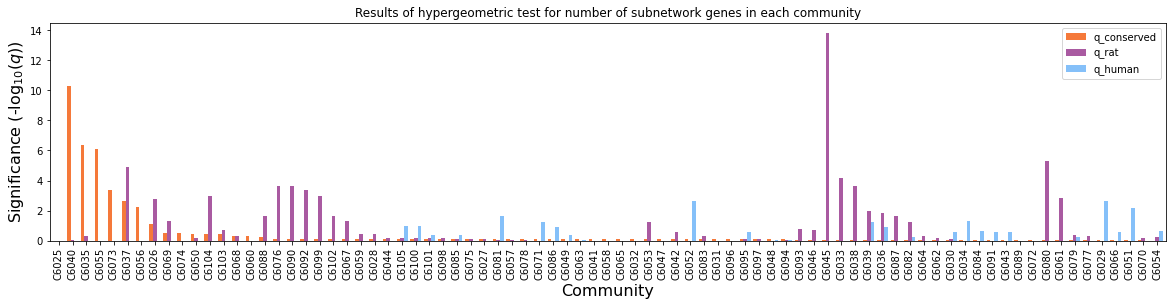

In [112]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
plot_data = all_hier_df.sort_values(by=["q_conserved", "q_rat", "q_human"]).loc[:, ("q_conserved", "q_rat", "q_human")]
(-1 * np.log10(plot_data)).plot.bar(ax=ax, width=0.8, color=["#f5793a", "#a95aa1", "#85c0f9"])
plt.xlabel("Community", fontsize=16)
_ = plt.ylabel("Significance (-log$_{10}(q)$)", fontsize=16)
_ = plt.title("Results of hypergeometric test for number of subnetwork genes in each community")

## <a id='toc5_7_'></a>[ADDED MGD Enrichment](#toc0_)

In [123]:
all_hier_df.head()

,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,...,p_rat,p_human,p_conserved,q_rat,q_human,q_conserved,sig_rat,sig_human,sig_conserved,sig_network
C6025,"[RP9P, PCDHGA12, MLXIP, CHPF, GRB10, FCHSD1, Z...",6022,False,12.556,NaN,NaN,0,0.0,0.0,113,...,0.000000,0.606457,0.000000,0.000000,0.999983,0.000000,1,0,1,ratconserved
C6026,"[HOXB9, PKIA, PCDHGA12, P2RX6, CNTN5, BARHL2, ...",2493,False,11.284,NaN,NaN,0,0.0,0.0,19,...,0.000309,0.918908,0.008275,0.001786,0.999983,0.083789,1,0,0,rat
C6028,"[RAB7B, FBXO25, RP9P, IGF2R, TCAF1, ZFP62, KDM...",1188,False,10.214,NaN,NaN,0,0.0,0.0,5,...,0.135187,0.999983,0.376671,0.377591,0.999983,0.736591,0,0,0,NaN
C6029,"[CKAP5, DTD1, SLC3A2, TRAIP, POLR2C, CLN3, CPO...",1144,False,10.160,NaN,NaN,0,0.0,0.0,14,...,0.942474,0.000032,0.882806,0.999976,0.002223,0.935703,0,1,0,human
C6041,"[SGK3, PRKX, MAP2K6, STK36, DAPK2, STK33, HIPK...",87,False,6.443,NaN,NaN,0,0.0,0.0,44,...,0.999976,0.801528,0.235666,0.999976,0.999983,0.736591,0,0,0,NaN


In [125]:
# load mappings between genes and mammalian phenotypes
mgi_df = load_MGI_mouseKO_data(url='http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt', 
                               map_using="mgi", update=False, data_loc=DATADIR+"Reference/")

In [126]:
symbol_list = {'GARS': 'GARS1',
 'GGT2': 'GGT2P',
 'MARS': 'MARS1',
 'HIST1H2BC': 'H2BC4',
 'GBA': 'GBA1',
 'HIST1H2BG': 'H2BC8',
 'HIST1H2BF': 'H2BC7',
 'HIST1H2BE': 'H2BC6',
 'HIST1H2BI': 'H2BC10',
 'CBWD3': 'ZNG1C',
 'BHLHB9': 'GPRASP3',
 'ELOA3': 'ELOA3P',
 'ELOA3B': 'ELOA3BP',
 'SMIM11B': 'SMIM11',
 'CBSL': 'CBS',
 'C2orf27B': 'CDRT15P3',
 'LINC00846': 'TCP10L'}

In [127]:
def update_nodes(nodelist, manual_updates=None):
    approved = mg.querymany(nodelist, as_dataframe=True, species='human', scopes='symbol', fields='symbol')
    approved["input"] = approved.index
    approved = approved.drop_duplicates(subset=["input", "symbol"])
    missing = approved[~approved.notfound.isna()].input.values
    missing_df = mg.querymany(missing,as_dataframe=True, species='human', scopes='alias', fields='symbol')
    dups = missing_df.loc[missing_df.index.duplicated()].index.values
    if manual_updates is None:
        keep_dups = {}
        for gene in dups:
            print(missing_df.loc[gene])
            keep_dups[gene] = input()
    else:
        keep_dups = manual_updates
    missing_df = missing_df.loc[~missing_df.index.isin(dups)]
    approved = approved[approved.notfound.isna()]
    dup_df = pd.DataFrame({"symbol":keep_dups.values()}, index=keep_dups.keys())
    out_df = pd.concat([approved, missing_df[missing_df.notfound.isna()], dup_df])
    return out_df, keep_dups

In [128]:
updated_pc_nodes, _ = update_nodes(pc_nodes, symbol_list)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-18820...done.
Finished.
228 input query terms found dup hits:
	[('TCEA1P2', 2), ('USP12P1', 2), ('TBC1D29P', 2), ('RAB42P1', 2), ('WDR82P1', 3), ('FBXL21P', 2), ('
577 input query terms found no hit:
	['EEF1AKNMT', 'AC022826.2', 'TMEM189-UBE2V1', 'WRB', 'ARNTL', 'KIF1BP', 'TTC37', 'TMEM251', 'MARCH5'
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-577...done.
Finished.
17 input query terms found dup hits:
	[('GARS', 2), ('GGT2', 2), (

In [129]:
mgi_df = change_symbols(mgi_df, updated_pc_nodes)

In [130]:
MPO = load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology', 
                          use_genes=True, mapping=mgi_df, data_loc=DATADIR+"Reference/", update=False)

14555


In [131]:
term_counts, gene_mapping, term_mapping = genes_per_node(MPO)

In [132]:
mp_graph = get_mp_graph(DATADIR+"Reference/parsed_mp.txt")

In [398]:
if True:
    bmi_phenotypes = []
    for community in tqdm(all_hier_df.index):
        x = community_term_enrichment(community,  all_hier_df, MPO, mgi_df, term_counts, gene_mapping, G_int=G)
        x = x.assign(name=community)
        bmi_phenotypes.append(x)
    bmi_pheno_results = pd.concat(bmi_phenotypes)
    bmi_pheno_results.to_csv(DATADIR + "outputs/RERUN_expand_hierarchy_MGD_Full_enrichment_results.tsv", sep="\t")

100%|██████████| 137/137 [00:48<00:00,  2.82it/s]


0/4 in MPO.genes/seeds


In [399]:
body_size_terms = [num_to_mp(x) for x in [1697, 10866, 3956, 5451]]
body_size_enrichments = bmi_pheno_results[bmi_pheno_results.OR_p<0.05].loc[body_size_terms].sort_values(by="OR_p")

In [403]:
system_names = pd.read_csv(DATADIR + "outputs/rerun_species_expandd_hierarchy_system_names.tsv", sep="\t", names=["name", "annotation"], skiprows=1)
system_names.head()

,name,annotation
0,C2270,proteoglycan biosynthetic process
1,C2304,protein processing
2,C2313,C2313
3,C2314,C2314
4,C2315,carbohydrate transport


In [404]:
body_size_enrichments["MP"] = body_size_enrichments.index

In [405]:
body_size_enrichments = body_size_enrichments.expand(system_names, on="name", how='left')

In [172]:
ors = body_size_enrichments.pivot_table(values="OR", columns ="description", index="name").fillna(0)

In [171]:
pvals = body_size_enrichments.pivot_table(values="OR_p", columns ="description", index="name").fillna(1)

In [175]:
ors[pvals >0.05] = 0

In [176]:
ors

description,abnormal body composition,abnormal body size,abnormal embryo size,abnormal prenatal body size
name,,,,
C6025,1.247271,1.283264,1.480298,1.465953
C6026,1.364501,1.376595,0.000000,0.000000
C6027,1.395540,1.300738,0.501237,0.575052
C6028,1.229434,1.244609,1.457928,1.420106
C6029,0.000000,0.000000,2.238287,2.107526
C6030,0.798823,0.768251,1.637416,1.595764
C6031,1.941365,1.677239,2.011435,2.020635
C6032,1.863191,1.619335,1.642572,1.846559
C6034,0.000000,0.000000,3.803150,3.654473


In [180]:
ors.to_csv("/cellar/users/snwright/Data/Transfer/rat/expanded_hierarchy_enrichments_sig.tsv", sep="\t")

In [249]:
human_list = ["C6029","C6034",  "C6052", "C6081", "C6051"]
conserved_list = ["C6055", "C6056","C6073", "C6035", "C6040", "C6037"]
rat_list = ["C6061", "C6033", "C6038", "C6088", "C6036", "C6039", "C6080","C6090", "C6087", "C6045", "C6076"]
comms = human_list+conserved_list + rat_list

In [406]:
body_size_enrichments = body_size_enrichments.set_index("MP")

In [407]:
body_size_enrichments.index.name=None

In [356]:
comms = ["C6247",
"C6242",
"C6229",
"C6227",
"C6226",
"C6225",
"C6206",
"C6201",
"C6200",
"C6199",
"C6197",
"C6195",
"C6188",
"C6183",
"C6176",
"C6167",
"C6163",
"C6160",
"C6157",
"C6153",
"C6151",
"C6150",
"C6146",
"C6136",
"C6134",
"C6129",
"C6128",
"C6124",
"C6122",
"C6119",
"C6116",
"C6114",
"C6113",
"C6112",
"C6108",
"C6099",
"C6092",
"C6091",
"C6090",
"C6086",
"C6080",
"C6073",
"C6069",
"C6062",
"C6057",
"C6053",
"C6052",
"C6049",
"C6047",
"C6046",
"C6043",
"C6040",
"C6036",
"C6035",
"C6034",
"C6033",
"C6032",
"C6031",
"C6029",
"C6028",
"C6027",
"C6026",
"C6025"]

In [411]:
all_hier_df.sig_network.value_counts()

human                44
rat                  26
ratconserved         20
conserved            19
rathuman             13
humanconserved        9
rathumanconserved     6
Name: sig_network, dtype: int64

In [408]:
body_size_enrichments.head()

,observed,total,OR,OR_p,OR_CI_lower,OR_CI_upper,hyper_p,sig_5e6,description,size,name,annotation
MP:0010866,112.0,1088.0,1.974383,9.521199e-11,1.606928,2.425864,5.780056e-10,True,abnormal prenatal body size,1086.0,C2271,demethylation
MP:0001697,96.0,912.0,2.010458,5.858471e-10,1.611857,2.507629,3.130741e-09,True,abnormal embryo size,1086.0,C2271,demethylation
MP:0010866,9.0,1088.0,7.034688,1.052780e-06,3.214173,15.396443,4.150481e-06,True,abnormal prenatal body size,30.0,C2285,chromosome organization
MP:0001697,8.0,912.0,7.194690,1.902971e-06,3.194390,16.204525,8.063826e-06,False,abnormal embryo size,30.0,C2285,chromosome organization
MP:0005451,13.0,2776.0,6.857796,2.680716e-06,3.069231,15.322851,1.012624e-06,True,abnormal body composition,24.0,C2288,adenylate cyclase-modulating G protein-coupled...


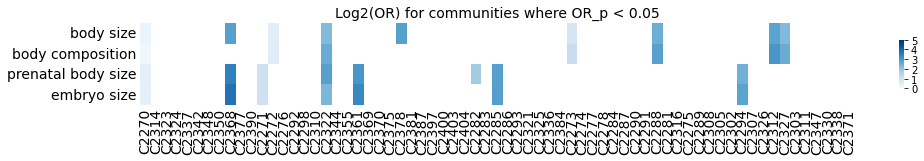

In [431]:
_ = plot_community_heatmap(body_size_enrichments, [body_size_terms[i] for i in [2,3,1,0]],all_hier_df[all_hier_df.sig_network.isin(["conserved", "ratconserved", "rathumanconserved", "humanconserved", "rathuman"])].index,  annotations=None, stat="OR", filter_stat="OR_p", 
                       color_range = [0, 5], MPO=MPO, vert = 1.5, horz=16, xlabel="annotation", filter_th=0.05)

In [434]:
system_names[system_names["name"].isin(["C2368", "C2322", "C2361", "C2378", "C2282", "C2285", "C2288", "C2294", "C2312", "C2327"])]

,name,annotation
16,C2368,regulation of ERBB signaling pathway
35,C2322,demethylation
47,C2361,C2361
55,C2378,C2378
75,C2282,chromatin organization
77,C2285,chromosome organization
106,C2288,adenylate cyclase-modulating G protein-coupled...
115,C2294,cell division
118,C2312,adenylate cyclase-inhibiting G protein-coupled...
119,C2327,adenylate cyclase-modulating G protein-coupled...


In [437]:
system_names[system_names["name"].isin(["C2341", "C2402", "C2366", "C2360", "C2351", "C2354"])]

,name,annotation
13,C2351,cellular respiration
42,C2354,C2354
46,C2360,protein import into nucleus
48,C2366,C2366
94,C2402,C2402
125,C2341,DNA repair


In [438]:
system_names[system_names["name"].isin(["C2357", "C2299"])]

,name,annotation
44,C2357,C2357
104,C2299,smoothened signaling pathway


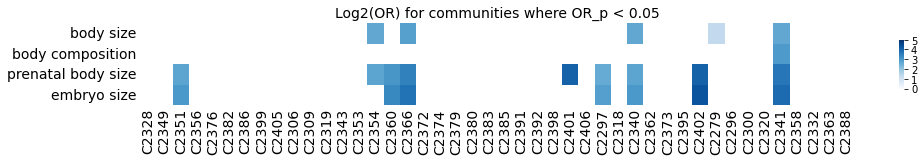

In [428]:
_ = plot_community_heatmap(body_size_enrichments, [body_size_terms[i] for i in [2,3,1,0]],all_hier_df[all_hier_df.sig_network.isin(["human"])].index,  annotations=None, stat="OR", filter_stat="OR_p", 
                       color_range = [0, 5], MPO=MPO, vert = 1.5, horz=16, xlabel="annotation", filter_th=0.05)

In [444]:
for sys in system_names.annotation:
    if "syn" in sys:
        print(sys)

proteoglycan biosynthetic process
small molecule biosynthetic process
proteoglycan biosynthetic process
carbohydrate derivative biosynthetic process
proteoglycan biosynthetic process


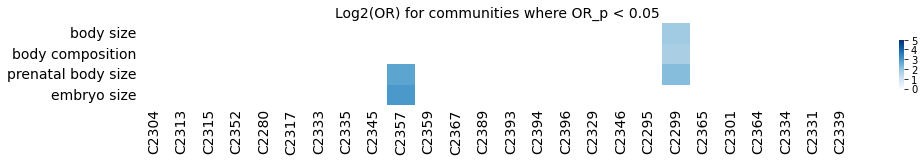

In [432]:
_ = plot_community_heatmap(body_size_enrichments, [body_size_terms[i] for i in [2,3,1,0]],all_hier_df[all_hier_df.sig_network.isin(["rat"])].index,  annotations=None, stat="OR", filter_stat="OR_p", 
                       color_range = [0, 5], MPO=MPO, vert = 1.5, horz=16, xlabel="annotation", filter_th=0.05)

In [424]:
all_hier_df[all_hier_df.sig_network=="humanconserved"].index

Index(['C2370', 'C2375', 'C2378', 'C2397', 'C2404', 'C2282', 'C2285', 'C2308',
       'C2294'],
      dtype='object')

In [422]:
all_hier_df.loc[["C2368", "C2273", "C2288", "C2327"]]

,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,...,p_rat,p_human,p_conserved,q_rat,q_human,q_conserved,sig_rat,sig_human,sig_conserved,sig_network
C2368,"[EGFR, ZFYVE28, NUMBL, SH3TC2, EHD4]",5,False,2.322,,,0,0.0,0.0,13,...,7.669279e-04,0.565555,1.090141e-02,2.101382e-03,0.752243,2.928417e-02,1,0,1,ratconserved
C2273,"[OR8S1, OR10A5, GRK5, F2R, TMEM236, OR6B2, QRF...",72,False,6.17,,,0,0.0,0.0,54,...,2.433504e-14,0.307143,4.617151e-10,2.222600e-13,0.452458,4.518212e-09,1,0,1,ratconserved
C2288,"[TMEM236, FFAR4, GAL, PRLHR, POMC, PTH2R, ADCY...",24,False,4.585,,,0,0.0,0.0,18,...,3.706075e-08,0.303851,2.868490e-03,2.115551e-07,0.452458,1.091620e-02,1,0,1,ratconserved
C2327,"[ADCYAP1, GPR176, MC4R, FFAR4, ADORA2A, VIPR1,...",10,False,3.322,,,0,0.0,0.0,6,...,2.163713e-05,0.811400,2.395092e-03,8.011588e-05,0.882236,9.943259e-03,1,0,1,ratconserved


In [370]:
body_size_enrichments[body_size_enrichments["name"]=="C6043"]

,observed,total,OR,OR_p,OR_CI_lower,OR_CI_upper,hyper_p,sig_5e6,description,size,name,annotation


In [252]:
from plotting_functions import *

In [279]:
??plot_community_heatmap

## <a id='toc5_8_'></a>[END ADDED](#toc0_)

## <a id='toc5_9_'></a>[ADDED Table 7 Analysis](#toc0_)

In [447]:
table7 = pd.read_csv("/cellar/users/snwright/Data/Transfer/rat/table7.tsv",sep="\t")

In [453]:
data.head()

,NPS_r,NPS_h,NPS_hr,subgraph,rat_seed,human_seed,overlapping_seeds
gene,,,,,,,
A1BG,0.125314,-0.488576,-0.061226,PCNet,0,0,0
A1CF,2.540447,2.186042,5.553524,Conserved,0,0,0
A2M,0.651845,-0.581848,-0.379275,PCNet,0,0,0
A2ML1,-1.315517,-1.108608,1.458393,PCNet,0,0,0
A3GALT2,-0.546107,-0.243477,0.132964,PCNet,0,1,0


In [454]:
table7["Network"] = table7.gene.apply(lambda x: data.loc[x].subgraph)

In [479]:
gene_counts = table7.groupby("Network").InMGD.sum()

In [467]:
plot_df[["PCNet", "Conserved", "Human-Specific", "Rat-Specific"]]

Network
PCNet         0.219094
Conserved     0.277017
Human-Only    0.268108
Rat-Only      0.220930
dtype: float64

In [484]:
def plot_validation_bars(data, gene_counts, ylabel='', idx=["Both", "Human", "Rat", "Network"],
                        labels = ["Human\n& Rat", "Human\nSeed", "Rat\nSeed", "Network\nImplicated"], ax=None):
    data = data[idx]
    gene_counts = gene_counts[idx]
    color_map = {"Both":"#0051a2", "Human":"#85c0f9", "Rat":"#a95aa1","Network":"#f5793a", "PCNet": "lightgrey", 
                 "All MGD":'lightgrey',  "Conserved":'peachpuff', "Human-Specific":'powderblue', "Rat-Specific":'plum'}
    if ax is None:
        _ = plt.figure(figsize=(3,2))
        ax = plt.gca()
    try:
        sns.barplot(x = data.index, y=data.values,palette=color_map, ax=ax)
    except:
        sns.barplot(x = data.index, y=data.values, ax=ax)
    plt.ylim((0, 1))
    ax.tick_params(pad=1, labelsize=7)
    ax.set_xlabel("Gene Source", fontsize=7)
    plt.sca(ax)
    plt.yticks([0,0.2,0.4, 0.6, 0.8, 1], labels=["0%", "20%", "40%", "60%", "80%", "100%"])
    ax.set_xticklabels(labels)
    ax.set_ylabel(ylabel, fontsize=7, labelpad=0)
    for i, bar in enumerate(data.index):
        ax.annotate("("+str(int(data[bar]*gene_counts[bar]))+")", xy=(i, data[bar]+0.02), ha='center', fontsize=7)
        ax.annotate(str(round(100*data[bar], 1))+"%", xy=(i, data[bar]+0.08), ha='center', fontsize=7)

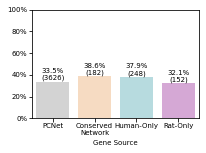

In [499]:
plot_df = table7.groupby("Network")["MGD:BodySize"].sum()/table7.groupby("Network").InMGD.sum()
plot_validation_bars(plot_df, gene_counts, idx=["PCNet", "Conserved", "Human-Specific", "Rat-Specific"], 
                     labels = ["PCNet", "Conserved\nNetwork", "Human-Specific", "Rat-Specific"])

In [486]:
results = {}
for comm in BMI_hier_df.index:
    genes = BMI_hier_df.loc[comm].CD_MemberList

    comm_df = table7[table7.gene.isin(genes)]
    results[comm] = comm_df.groupby("Network")["MGD:BodySize"].sum()/comm_df.groupby("Network").InMGD.sum()
results = pd.DataFrame.from_dict(results).T
results["mean"] = results.apply(lambda x: np.nanmean([x.Rat, x.Both, x.Human, x.Network]), axis=1)
results = results.sort_values(by="mean", ascending=False)

,gene,rat_seed,human_seed,both_seed,network_implicated,Conserved_Source,MP:0001697,MP:0010866,MP:0003956,MP:0005451,MP:0001261,MP:0020182,MGD:BodySize,MGD:Obesity/BMI,InMGD,Network
0,UBE2Q1,0,0,0,1,NaN,0,0,0,0,0,0,0,0,1,PCNet
1,RNF14,0,0,0,1,NaN,0,0,0,0,0,0,0,0,1,PCNet
2,UBE2Q2,0,1,0,0,NaN,0,0,0,0,0,0,0,0,0,PCNet
3,TMCO1,0,0,0,1,NaN,0,0,1,1,0,0,1,0,1,PCNet
4,UBAC1,0,0,0,1,NaN,0,0,0,0,0,0,0,0,1,PCNet


In [473]:
table7.groupby("Network")["MGD:BodySize"].sum()

Network
Conserved      182
Human-Only     248
PCNet         3626
Rat-Only       152
Name: MGD:BodySize, dtype: int64

In [475]:
table7.groupby("Conserved_Source")["MGD:BodySize"].sum()

Conserved_Source
Both        6
Human      57
Network    92
Rat        27
Name: MGD:BodySize, dtype: int64

In [477]:
table7.groupby("Network").InMGD.sum()

Network
Conserved       472
Human-Only      654
PCNet         10809
Rat-Only        474
Name: InMGD, dtype: int64

In [462]:
plot_df

Network
Conserved     0.277017
Human-Only    0.268108
PCNet         0.219094
Rat-Only      0.220930
dtype: float64

## <a id='toc5_10_'></a>[END ADDED](#toc0_)

# <a id='toc6_'></a>[Scaled Figures](#toc0_)

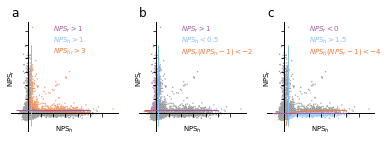

In [537]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(6.5, 2))
plot_species_nps(data, "conserved", conserved, ax1)
plot_species_nps(data, "rat", rat_only, ax2)
plot_species_nps(data, "human", human_only, ax3)
ax1.set_title("a", loc="left", fontsize=12)
ax2.set_title("b", loc="left", fontsize=12)
ax3.set_title("c", loc="left", fontsize=12)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])
#plt.savefig(FIGDIR + "definition_of_networks.png", dpi=400, bbox_inches="tight")
plt.savefig("/cellar/users/snwright/Data/Transfer/rat/UpdatedFigures/resub_threshold_plots_no_axis labels.png", dpi=600, bbox_inches="tight")

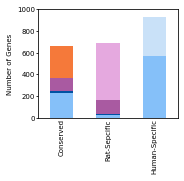

In [65]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2.5,2))
subgraph_stats.loc[["Conserved", "Rat-Specific", "Human-Specific"]].plot(kind="bar", stacked=True, ax=ax,
                                                                 color=["#85c0f9", "#0051a2","#a95aa1", "#F5793a", "#e5a9df", "#c9e1f8"])
plt.legend(ncol=2, handletextpad=0.3, labelspacing=0.2, borderpad=0.4, columnspacing=0.5, fontsize=7, frameon=False)
#plt.ylim((0, 1300))
ax.get_legend().remove()
plt.xticks(fontsize=7)
plt.yticks([0,200, 400, 600, 800, 1000],fontsize=7)
ax.set_xticklabels(labels=["Conserved", "Rat-Sepcific", "Human-Specific"])
plt.xlabel(None)
ax.tick_params(axis='x', pad=1, length=0)
ax.tick_params(axis='y', pad=1, length=2)
plt.ylabel("Number of Genes", fontsize=7)
plt.savefig(FIGDIR+"species_specific_bars_scaled.png",  dpi=400, bbox_inches="tight")

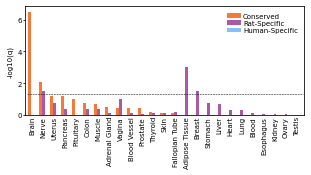

In [66]:
human_te.columns = ["Conserved", "Rat-Specific", "Human-Specific"]
human_te = human_te.sort_values(by=["Conserved", "Rat-Specific"], ascending=False)
fig, ax = plt.subplots(figsize=(5,2))
human_te.plot.bar(ax=ax, width=0.8, color=["#f5793a", "#a95aa1", "#85c0f9"], fontsize=7)
ax.set_ylabel("-log10(q)", fontsize=7)
ax.set_xlabel(None)
plt.hlines(-1 *np.log10(0.05),-0.5, 24.5, color="black", linestyle="dashed", linewidth=0.5)
plt.legend(fontsize=7, frameon=False,handletextpad=0.3, labelspacing=0.2 )
plt.tick_params(axis='x', pad=1, length=0)
plt.tick_params(axis='y', pad=1, length=2)
plt.yticks([0,2,4,6])
plt.savefig(FIGDIR+"tissue_enrichment_human_GTEx_scaled.png", bbox_inches="tight", dpi=400)


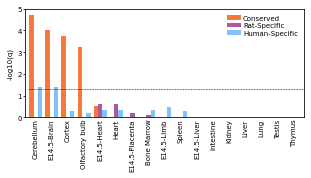

In [67]:
mouse_te.columns = ["Conserved", "Rat-Specific", "Human-Specific"]
mouse_te = mouse_te.sort_values(by=["Conserved", "Rat-Specific", "Human-Specific"], ascending=False)
fig, ax = plt.subplots(figsize=(5,2))
mouse_te.plot.bar(ax=ax, width=0.8, color=["#f5793a", "#a95aa1", "#85c0f9"], fontsize=7)
ax.set_ylabel("-log10(q)", fontsize=7)
ax.set_xlabel(None)
plt.hlines(-1 *np.log10(0.05),-0.5, 24.5, color="black", linestyle="dashed", linewidth=0.5)
plt.legend(fontsize=7, frameon=False,handletextpad=0.3, labelspacing=0.2 )
plt.tick_params(axis='x', pad=1, length=0)
plt.tick_params(axis='y', pad=1, length=2)
plt.yticks([0,1,2,3,4,5])
#plt.title("Enrichment of Tissue-Specific Genes from mouse ENCODE")
plt.savefig(FIGDIR+"tissue_enrichment_mouse_ENCODE_scaled.png", bbox_inches="tight", dpi=400)